In [3]:
import iris
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs
import iris.analysis.cartography

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'

In [4]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/{yrs_range}/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)

file_model_12km_wgs84 ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km_wgs84/01/1980_2001/wgs84_pr_rcp85_land-rcm_uk_12km_01_day_20701201-20801130.nc'
cube_12km_wgs84 =iris.load_cube(file_model_12km_wgs84)

# remove ensemble member dimension
cube_2km = cube_2km[0,:,:,:]
cube_12km = cube_12km[0,:,:,:]

In [5]:
# Define the target CRS (WGS84 for intermediate step)
target_crs = ccrs.Geodetic()
bng_crs = ccrs.OSGB()
# Define BNG system
os_gb=TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, 
                         false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, 
                         ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))

## Transform cube 2.2km to BNG

In [42]:
def convert_rotatedpol_to_bng(cube):
    # Define the original crs (rotated pole) and the target crs (BNG)
    source_crs = ccrs.RotatedGeodetic(pole_latitude=37.5,
                                      pole_longitude=177.5,
                                      central_rotated_longitude=0)
    target_crs = ccrs.OSGB()

    # Extract the 2D meshgrid of lats/lons in rotated pole
    x = cube.coord('grid_longitude').points # long
    y = cube.coord('grid_latitude').points # lat
    # Convert to 2D
    xx, yy = np.meshgrid(x, y)

    # Use transform_points to project your coordinates into BNG
    transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

    # Reshape the array back to your original grid shape and separate the components
    lons_bng, lats_bng = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

    # Here's a simplified way to create a new cube with the transformed coordinates,
    # assuming your original data is 2-dimensional and compatible with the new grid.
    new_cube_data = cube.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
    latitude_coord = iris.coords.DimCoord(lats_bng[:, 0], standard_name='projection_y_coordinate', units='m',
                                          coord_system=os_gb)
    longitude_coord = iris.coords.DimCoord(lons_bng[0, :], standard_name='projection_x_coordinate', units='m',
                                          coord_system=os_gb)

    # Guess bounds
    latitude_coord.guess_bounds()
    longitude_coord.guess_bounds()

    cube_2km_bng = cube.copy()
    cube_2km_bng.remove_coord('grid_latitude')
    cube_2km_bng.remove_coord('grid_longitude')
    # If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
    cube_2km_bng.add_dim_coord(latitude_coord, 1)  # Assuming latitude corresponds to the first dimension
    cube_2km_bng.add_dim_coord(longitude_coord, 2)  # And longitude to the second
    
    return cube_2km_bng

In [6]:
# Define the original crs (rotated pole) and the target crs (BNG)
source_crs = ccrs.RotatedGeodetic(pole_latitude=37.5,
                                  pole_longitude=177.5,
                                  central_rotated_longitude=0)
target_crs = ccrs.OSGB()

# Extract the 2D meshgrid of lats/lons in rotated pole
x = cube_2km.coord('grid_longitude').points # long
y = cube_2km.coord('grid_latitude').points # lat
# Convert to 2D
xx, yy = np.meshgrid(x, y)

# Use transform_points to project your coordinates into BNG
transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

# Reshape the array back to your original grid shape and separate the components
lons_bng, lats_bng = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

# Here's a simplified way to create a new cube with the transformed coordinates,
# assuming your original data is 2-dimensional and compatible with the new grid.
new_cube_data = cube_2km.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
latitude_coord = iris.coords.DimCoord(lats_bng[:, 0], standard_name='projection_y_coordinate', units='m',
                                      coord_system=os_gb)
longitude_coord = iris.coords.DimCoord(lons_bng[0, :], standard_name='projection_x_coordinate', units='m',
                                      coord_system=os_gb)

# Guess bounds
latitude_coord.guess_bounds()
longitude_coord.guess_bounds()

cube_2km_bng = cube_2km.copy()
cube_2km_bng.remove_coord('grid_latitude')
cube_2km_bng.remove_coord('grid_longitude')
# If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
cube_2km_bng.add_dim_coord(latitude_coord, 1)  # Assuming latitude corresponds to the first dimension
cube_2km_bng.add_dim_coord(longitude_coord, 2)  # And longitude to the second

### Plot the original

In [7]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_2km_bng[100,:,:])
# # iplt.pcolormesh(cube_2km[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Plot the BNG version

In [8]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_bng[100,:,:])
# # iplt.pcolormesh(cube_bng[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Matplotlib plotting version

In [9]:
# # Create a figure and axis with a geographic projection (PlateCarree is common for WGS84 data)
# fig, axs = plt.subplots(ncols=2, figsize=(10, 10), subplot_kw={'projection': ccrs.OSGB()})
# # ax.set_global()  # Optional: Sets the extent of the map to the global extent
# # ax.set_extent([0, 800000, 0, 1300000], crs=bng_crs)
# # [-13, 3, 49, 61]

# # Original data
# axs[0].coastlines()
# # Plot the data using pcolormesh, specifying the projection of the data ('transform' argument)
# axs[0].contourf(lons, lats, new_cube_data[100,:,:], transform=ccrs.OSGB(), shading='auto')
# # Add a colorbar
# # plt.colorbar(mesh, ax=axs[0], shrink=0.5, label='Data values')

# # Original data
# axs[1].coastlines()
# # Plot the data using pcolormesh, specifying the projection of the data ('transform' argument)
# axs[1].contourf(yy, xx, new_cube_data[100,:,:], transform=ccrs.OSGB(), shading='auto')

## Regrid to 12km

In [10]:
cube_2km_bng_regridded_12km = cube_2km_bng.regrid(cube_12km, iris.analysis.AreaWeighted()) 

In [11]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_2km_bng_regridded_12km[100,:,:])
# # iplt.pcolormesh(cube_bng[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [12]:
# fig, ax = plt.subplots(figsize=(10, 10))
# iplt.contourf(cube_12km[100,:,:])
# # iplt.pcolormesh(cube_bng[100,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [13]:
import numpy as np

# Assuming your cube's latitude and longitude are 2D AuxCoords
lats = cube_2km.coord('grid_latitude').points
lons = cube_2km.coord('grid_longitude').points
xx,yy=np.meshgrid(lats, lons)
lats_flat= xx.flatten()
lons_flat = yy.flatten()

# Perform the transformation
transformed_points = target_crs.transform_points(source_crs, lons_flat, lats_flat)

# Extract the easting and northing (ignore the third column which is the altitude)
eastings, northings = transformed_points[:, 0], transformed_points[:, 1]

# eastings.reshape(lats.shape)
lats_flat.shape

(293304,)

## Transform cube 2.2km to WGS84 and then to 12km

In [14]:
# this is the crs that we want to transform to
source_crs_2km = ccrs.RotatedGeodetic(pole_latitude=37.5,
                                        pole_longitude=177.5,
                                        central_rotated_longitude=0)

# these are the crs we are transforming from
target_crs = ccrs.Geodetic()

transverse_mercator_crs = ccrs.TransverseMercator(
    central_longitude=-2.0,
    central_latitude=49.0,
    false_easting=400000,
    false_northing=-100000,
    scale_factor=0.9996012717,
    globe=ccrs.Globe(semimajor_axis=6377563.396, semiminor_axis=6356256.909))

In [20]:
source_crs = source_crs_2km
target_crs = ccrs.Geodetic()
cube = cube_2km
x_coord_name = "grid_longitude"
y_coord_name = "grid_latitude"

# Extract the 2D meshgrid of X (eastings) and Y (northings) coordinates from the cube
x = cube.coord(x_coord_name).points
y = cube.coord(y_coord_name).points
xx, yy = np.meshgrid(x, y)

if cube.coords('latitude', dim_coords=False):
    cube.remove_coord("latitude")
if cube.coords('longitude', dim_coords=False):
    cube.remove_coord("longitude")

# Also get time for the new cube
time_coord = cube.coord('time')

# Use transform_points to project your coordinates
transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

# transformed_points now has a shape (n*m, 3), where the last dimension contains (lon, lat, z)
# Reshape the array back to your original grid shape and separate the components
lons_wgs84, lats_wgs84 = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

#Now, you should create a new cube with these lons and lats as coordinates.
#Note: This step requires careful handling to ensure the new cube's data aligns correctly with the transformed coordinates.
#You might need to create new latitude and longitude DimCoords, ensuring they have bounds set if performing area-weighted regridding later.

# Here's a simplified way to create a new cube with the transformed coordinates,
# assuming your original data is 2-dimensional and compatible with the new grid.
new_cube_data = cube.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
latitude_coord = iris.coords.DimCoord(lats_wgs84[:, 0], standard_name='latitude', units='degrees')
longitude_coord = iris.coords.DimCoord(lons_wgs84[0, :], standard_name='longitude', units='degrees')

# Guess bounds
latitude_coord.guess_bounds()
longitude_coord.guess_bounds()

cube_2km_wgs84 = cube.copy()
cube_2km_wgs84.remove_coord(x_coord_name)
cube_2km_wgs84.remove_coord(y_coord_name)
# If your data is indeed 2-dimensional as suggested, these should be added as dimension coordinates
cube_2km_wgs84.add_dim_coord(latitude_coord, 1)  # Assuming latitude corresponds to the first dimension
cube_2km_wgs84.add_dim_coord(longitude_coord, 2)  # And longitude to the second

In [16]:
cart = ccrs.RotatedPole(pole_longitude=177.5, 
                       pole_latitude=37.5,
                       # central_rotated_longitude=-106.0, 
                       globe = ccrs.Globe(semimajor_axis=6371229.0,
                                semiminor_axis=6371229.0))

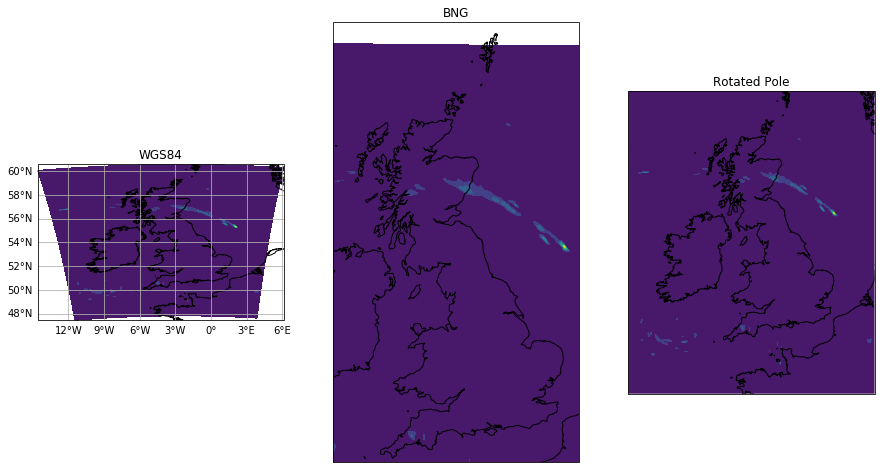

In [17]:
# Create a figure
fig = plt.figure(figsize=(15, 10))

# Create the first subplot with one projection
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('WGS84')
ax1.contourf(lons_wgs84, lats_wgs84, new_cube_data[100,:,:], transform=ccrs.PlateCarree(), shading='auto')
gl = ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.OSGB())
ax2.coastlines()
ax2.set_title('BNG')
ax2.contourf(lons_bng, lats_bng, new_cube_data[100,:,:], transform=ccrs.OSGB(), shading='auto')
# gl = ax2.gridlines(draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

ax3 = fig.add_subplot(1, 3, 3, projection=cart)
ax3.coastlines()
ax3.set_title('Rotated Pole')
ax3.contourf(xx, yy, new_cube_data[100,:,:], transform=cart, shading='auto');
# gl = ax3.gridlines(draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

## Convert to 12km

In [33]:
# An alternative is to use a logarithmmic spacing (see lower down)
number_many_linear_bins=20 # Number of bins for improved plots with equal bins
power_for_unequal_bins=3.0 # Power used for generating unequal bins
number_unequal_bins=12 # Number of unequal bins 
unequal_min=0.1 # Must be zero or bigger for this approach to work
unequal_max=1.01*np.nanmax(cube_2km_bng_regridded_12km_data) # Ensure this is greater than the largest number
# N-th root (e.g. third root) of bin edges for manual bin edge spacing
unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
bins_i_want=unequal_linspace**power_for_unequal_bins
bins_i_want

array([1.00000000e-03, 7.78948097e-02, 4.28912553e-01, 1.26398984e+00,
       2.79306327e+00, 5.22606945e+00, 8.77294499e+00, 1.36436265e+01,
       2.00480506e+01, 2.81961538e+01, 3.82978728e+01, 5.05631443e+01])

In [35]:
def calculate_ccdf_wetvalues(precipitation_data, bins_i_want, filter_small_vals=False):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]

    # Compute the cumulative distribution function (CDF) using the histogram
    # np.diff(bin_edges): Calculate the differences between bin edges to get bin widths
    # hist * np.diff(bin_edges): Multiply each histogram value by its corresponding bin width
    # np.cumsum(): Compute the cumulative sum of the products
    # cdf: The cumulative distribution function values
    hist, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    
    # Calculate 1 - CDF for CCDF
    ccdf = 1 - cdf
    
    # Find the centre point of each bin for plotting
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return cdf, ccdf, bin_centres, bin_edges[1:]

In [ ]:
cube_2km_bng_regridded_12km = cube_2km_bng.regrid(cube_12km, iris.analysis.AreaWeighted()) 
cube_2km_wgs84_regridded_12km = cube_2km_wgs84.regrid(cube_12km_wgs84, iris.analysis.AreaWeighted()) 

In [32]:
cube_2km_bng_regridded_12km_data = cube_2km_bng_regridded_12km.data
ccube_2km_wgs84_regridded_12km_data = cube_2km_wgs84_regridded_12km.data

In [37]:
bng_cdf, bng_ccdf, bng_bin_centres, bng_bin_edges = calculate_ccdf_wetvalues(cube_2km_bng_regridded_12km_data, bins_i_want)
wgs84_cdf, wgs84_ccdf, wgs84_bin_centres, wgs84_bin_edges = calculate_ccdf_wetvalues(ccube_2km_wgs84_regridded_12km_data,bins_i_want)

Text(0.5,1,'CCDF')

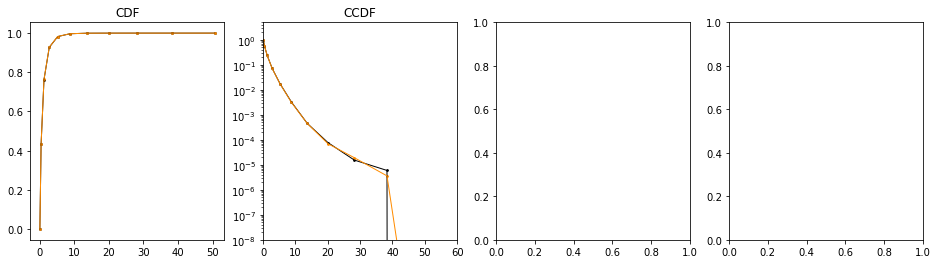

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(bng_bin_edges, bng_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(bng_bin_edges,bng_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(wgs84_bin_edges, wgs84_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(wgs84_bin_edges,wgs84_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(bng_bin_edges, bng_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(bng_bin_edges,bng_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(wgs84_bin_edges, wgs84_ccdf ,linewidth = 1,s=3, color = 'darkorange')
axs[1].plot(wgs84_bin_edges,wgs84_ccdf ,linewidth = 1, color = 'darkorange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

# axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
# axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
# axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
# axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
# axs[2].set_xlim(0.95,1.15)
# axs[2].set_ylim(0.225,0.35)
# axs[2].set_title('CCDF low values')

# axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
# axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
# axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
# axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
# axs[3].set_title('PDF')
# axs[3].set_yscale('log')
# axs[3].set_xlim(0.95,70)
# axs[3].set_ylim(1e-8,5)
# axs[3].legend(handles=patches);